In [7]:
import json, os, glob, random, lxml
from Queue import Queue
from threading import Thread, Lock
import h5py

import numpy as np
import matplotlib.pyplot as plt

from scipy.misc import imread, imresize
from scipy.io import loadmat

%matplotlib inline

In [38]:
DET_TRAIN_DIR = 'data/imagenet/ILSVRC2014_DET_train'
DEVKIT_DIR = 'data/imagenet/ILSVRC2014/ILSVRC2014_devkit'
VAL_BBOX_DIR = 'data/imagenet/ILSVRC2013_DET_bbox_val'
NUM_SYNSETS = 200

In [3]:
# Load info about synsets from the meta_det.mat file.

meta_det_path = os.path.join(DEVKIT_DIR, 'data/meta_det.mat')
print 'Loading meta_det from: ', meta_det_path
meta_det = loadmat(meta_det_path)

# This will be a list of dicts, each with the following three fields:
# - det_id: Integer from 1 to 200 giving ID of the synset for detection data
# - wnid: String giving WordNet ID of the synset
# - name: String giving human-readable name of the synset
synset_info = []

# The meta_det struct contains info about 815 synsets including parents and
# children of the 200 synsets actually used for detection. We only want to
# grab info about the first 200.
for i in xrange(NUM_SYNSETS):
  synset = meta_det['synsets'][0, i]
  det_id = int(synset[0][0, 0])
  wnid = str(synset[1][0])
  assert synset[2].shape == (1,)
  name = str(synset[2][0])
  synset_info.append({
    'det_id': det_id,
    'wnid': wnid,
    'name': name,
  })
  # print det_id, wnid, name
  
# print json.dumps(synset_info, indent=2)

Loading meta_det from:  data/imagenet/ILSVRC2014/ILSVRC2014_devkit/data/meta_det.mat


In [4]:
# Now that we have info about all detection synsets, we need to read
# the text files in the det_lists directory to figure out which images
# correspond to each synset.

det_lists_dir = os.path.join(DEVKIT_DIR, 'data/det_lists')

def read_image_ids(filename):
  with open(filename, 'r') as f:
    return [line.strip() for line in f]

all_image_ids = set()
  
for i, synset in enumerate(synset_info):
  if (i + 1) % 50 == 0:
    print 'Starting synset %d / %d' % (i + 1, len(synset_info))
  det_id = synset['det_id']
  pos_file = os.path.join(det_lists_dir, 'train_pos_%d.txt' % det_id)
  neg_file = os.path.join(det_lists_dir, 'train_neg_%d.txt' % det_id)
  part_file = os.path.join(det_lists_dir, 'train_part_%d.txt' % det_id)
      
  synset['pos_image_ids'] = read_image_ids(pos_file)
  synset['neg_image_ids'] = read_image_ids(neg_file)
  synset['part_image_ids'] = read_image_ids(part_file)
  
  all_image_ids.update(synset['pos_image_ids'])
  all_image_ids.update(synset['neg_image_ids'])
  all_image_ids.update(synset['part_image_ids'])
  
# According to the devkit readme.txt, there should be 456567 images in the
# detection training set. Make sure we found them all.
print len(all_image_ids)
assert len(all_image_ids) == 456567

Starting synset 50 / 200
Starting synset 100 / 200
Starting synset 150 / 200
Starting synset 200 / 200
456567


In [7]:
# Make sure that we can find the training images. It will take forever to
# check each one, so just randomly sample some and make sure we can find them.
num_to_check = 1000
image_ids_sample = random.sample(all_image_ids, num_to_check)

num_found = 0
for i, image_id in enumerate(image_ids_sample):
  if (i + 1) % 100 == 0:
    print 'Looking for image %d / %d' % (i + 1, len(all_image_ids))
  filename = os.path.join(DET_TRAIN_DIR, '%s.JPEG' % image_id)
  if os.path.isfile(filename):
    num_found += 1
  # print image_id, filename, os.path.isfile(filename)
  
assert num_found == num_to_check

Looking for image 100 / 456567
Looking for image 200 / 456567
Looking for image 300 / 456567
Looking for image 400 / 456567
Looking for image 500 / 456567
Looking for image 600 / 456567
Looking for image 700 / 456567
Looking for image 800 / 456567
Looking for image 900 / 456567
Looking for image 1000 / 456567


bench
pos examples


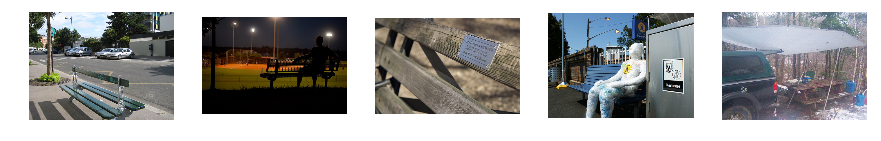

neg examples


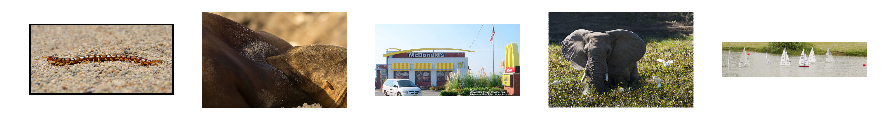

In [8]:
# Look at some random positive and negative images

images_to_show = 5

synset = random.choice(synset_info)
print synset['name']

def show_images(image_ids):
  for i, image_id in enumerate(image_ids):
    plt.subplot(1, len(image_ids), i + 1)
    img = imread(os.path.join(DET_TRAIN_DIR, '%s.JPEG' % image_id))
    plt.axis('off')
    plt.imshow(img)
  plt.gcf().set_size_inches(15, 12)
  plt.show()

print 'pos examples'
show_images(random.sample(synset['pos_image_ids'], images_to_show))

print 'neg examples'
show_images(random.sample(synset['neg_image_ids'], images_to_show))

In [5]:
# Since we only care about multilabel classification at the moment, we will
# be lazy and not even worry about loading up the bounding boxes for detection
# instances. We'll just build label matrices for positives and hard negatives.

image_id_to_idx = {image_id: idx for idx, image_id in enumerate(all_image_ids)}
idx_to_image_id = {idx: image_id for idx, image_id in enumerate(all_image_ids)}

name_to_det_id = {s['name']: s['det_id'] for s in synset_info}
det_id_to_name = {s['det_id']: s['name'] for s in synset_info}

print name_to_det_id

num_train_images = len(all_image_ids)
train_labels = np.zeros((num_train_images, NUM_SYNSETS), dtype=np.uint8)
train_hardnegs = np.zeros((num_train_images, NUM_SYNSETS), dtype=np.uint8)

for synset in synset_info:
  det_id = synset['det_id'] - 1
  for image_id in synset['pos_image_ids']:
    idx = image_id_to_idx[image_id]
    train_labels[idx, det_id - 1] = 1
  for image_id in synset['neg_image_ids']:
    idx = image_id_to_idx[image_id]
    train_hardnegs[idx, det_id - 1] = 1
  

{'antelope': 4, 'toaster': 183, 'popsicle': 133, 'ruler': 149, 'camel': 35, 'fox': 70, 'laptop': 101, 'vacuum': 191, 'bell pepper': 22, 'bookshelf': 27, 'swimming trunks': 174, 'artichoke': 7, 'flower pot': 68, 'pineapple': 126, 'chair': 43, 'dumbbell': 62, 'guacamole': 78, 'accordion': 1, 'backpack': 10, 'scorpion': 152, 'bench': 23, 'fig': 66, 'orange': 119, 'piano': 125, 'ski': 156, 'stove': 169, 'digital clock': 56, 'ping-pong ball': 127, 'dragonfly': 60, 'sunglasses': 173, 'head cabbage': 88, 'plastic bag': 130, 'miniskirt': 112, 'screwdriver': 153, 'bear': 20, 'unicycle': 190, 'chain saw': 42, 'tv or monitor': 189, 'tie': 181, 'tick': 180, 'pencil box': 121, 'coffee maker': 46, 'croquet ball': 51, 'power drill': 135, 'sofa': 164, 'pretzel': 136, 'punching bag': 139, 'perfume': 123, 'baby bed': 9, 'saxophone': 151, 'filing cabinet': 67, 'motorcycle': 114, 'turtle': 188, 'bow tie': 28, 'bicycle': 24, 'nail': 116, 'snowplow': 161, 'lion': 103, 'lobster': 106, 'zebra': 200, 'cattle':

In [29]:
import xml.etree.ElementTree as ET

xml_file = 'data/imagenet/ILSVRC2013_DET_bbox_val/ILSVRC2013_val_00004575.xml'

wnid_to_det_id = {s['wnid']: s['det_id'] for s in synset_info}


      
print read_val_xml(xml_file)

n03063338 46 coffee maker
n03761084 110 microwave
set([110, 46])


In [39]:
val_list_file = os.path.join(DEVKIT_DIR, 'data/det_lists/val.txt')

val_image_id_to_idx = {}
val_idx_to_image_id = {}

# Input is path to an xml file; returns a set of det_ids for the image
def read_val_xml(xml_file):
  tree = ET.parse(xml_file)
  root = tree.getroot()
  det_ids = set()
  for obj in root.findall('object'):
    wnid = obj.find('name').text
    det_id = wnid_to_det_id[wnid]
    name = det_id_to_name[det_id]
    print wnid, det_id, name
    det_ids.add(det_id)
  return det_ids

with open(val_list_file, 'r') as f:
  for idx, line in enumerate(f):
    image_id, _ = line.strip().split()
    val_image_id_to_idx[image_id] = idx
    val_idx_to_image_id[idx] = image_id
    xml_file = os.path.join(VAL_BBOX_DIR, '%s.xml' % image_id)
    det_ids = read_val_xml(xml_file)

n01726692 159 snake
n01726692 159 snake
n02346627 134 porcupine
n01503061 26 bird
n02346627 134 porcupine
n02346627 134 porcupine
n00007846 124 person
n00007846 124 person
n02084071 58 dog
n02084071 58 dog
n02084071 58 dog
n02084071 58 dog
n02769748 10 backpack
n02769748 10 backpack
n02769748 10 backpack
n07739125 5 apple
n07739125 5 apple
n07739125 5 apple
n07739125 5 apple
n07739125 5 apple
n01503061 26 bird
n03636649 100 lamp
n04379243 177 table
n02274259 34 butterfly
n02076196 154 seal
n00007846 124 person
n01639765 72 frog
n01503061 26 bird
n04379243 177 table
n03950228 128 pitcher
n01503061 26 bird
n02084071 58 dog
n02084071 58 dog
n01674464 105 lizard
n00007846 124 person
n04371430 174 swimming trunks
n01503061 26 bird
n01503061 26 bird
n01503061 26 bird
n02084071 58 dog
n01726692 159 snake
n04530566 197 watercraft
n04530566 197 watercraft
n00007846 124 person
n04026417 140 purse
n04026417 140 purse
n04026417 140 purse
n02769748 10 backpack
n02769748 10 backpack
n02769748 10 bac

In [6]:
# Make an HDF5 file with all images and all training labels

IMG_SIZE = 224
NUM_WORKERS = 10
NUM_IMAGES = 1000
H5_OUTPUT_FILE = 'data/ilsvrc-det.h5'

num_train_images = len(all_image_ids)
lock = Lock()

with h5py.File(H5_OUTPUT_FILE, 'w') as f:
  # f.create_dataset('train_labels', data=train_labels)
  # f.create_dataset('train_hardnegs', data=train_hardnegs)
  image_dset = f.create_dataset('train_images', (num_train_images, 3, IMG_SIZE, IMG_SIZE))
  print 'done creating dataset'
  
  q = Queue()
  for i, (image_id, idx) in enumerate(image_id_to_idx.iteritems()):
    filename = os.path.join(DET_TRAIN_DIR, '%s.JPEG' % image_id)
    q.put((idx, filename))
    if i >= NUM_IMAGES: break
      
  print 'done enqueing images'
      
  def worker():
    images_read = 0
    while True:
      idx, filename = q.get()
      img = imread(filename)
      # Handle grayscale
      if img.ndim == 2:
        img = img[:, :, None][:, :, [0, 0, 0]]
      img = imresize(img, (IMG_SIZE, IMG_SIZE))
      # Swap RGB to BGR
      img = img[:, :, [2, 1, 0]]
      images_read += 1
      
      lock.acquire()
      # if images_read % 100 == 0:
      print 'worker has read %d images; queue has %d remaining' % (images_read, q.qsize())
      image_dset[i] = img.transpose(2, 0, 1)  # Swap HWC -> CHW
      lock.release()
      q.task_done()
      
  for i in xrange(NUM_WORKERS):
    t = Thread(target=worker)
    t.daemon = True
    t.start()
  q.join()

done creating dataset
done enqueing images
worker has read 1 images; queue has 991 remaining
worker has read 1 images; queue has 990 remaining
worker has read 1 images; queue has 989 remaining
worker has read 1 images; queue has 988 remaining
worker has read 1 images; queue has 987 remaining
worker has read 1 images; queue has 986 remaining
worker has read 1 images; queue has 985 remaining
worker has read 1 images; queue has 984 remaining
worker has read 1 images; queue has 983 remaining
worker has read 1 images; queue has 982 remaining
worker has read 2 images; queue has 982 remaining
worker has read 2 images; queue has 980 remaining
worker has read 2 images; queue has 979 remaining
worker has read 2 images; queue has 979 remaining
worker has read 2 images; queue has 977 remaining
worker has read 2 images; queue has 976 remaining
worker has read 2 images; queue has 975 remaining
worker has read 2 images; queue has 974 remaining
worker has read 3 images; queue has 973 remaining
worker 